Menggunakan 27 kata dasar kustom.
--- Inisialisasi Stemmer ---
Stemmer Sastrawi (Kamus Kustom) siap.
Stemmer Snowball (English) siap.
-----------------------------

--- Memproses Dokumen Bahasa: Indonesia ---
Input: input/indo
Output Perbandingan: output/indo_comparison_simulated
Output Stemmed (IR): output/indo_stemmed
  -> Memproses: Kel3_Peran Bimbingan dan Konseling Dalam Pendidikan Karakter    .txt...
  -> Memproses: Kel6_Benarkah anak-anak butuh mata pelajaran koding dan AI di sekolah.txt...
  -> Memproses: Dampak Tarif Resiprokal Trump terhadap Industri di Indonesia_1.txt...
  -> Memproses: Global South dan Ilusi Netralitas_10.txt...
  -> Memproses: Eksistensi Media Massa Nasional_5.txt...
  -> Memproses: Peran Media Massa dalam Membentuk Opini Publik_5.txt...
  -> Memproses: Kelompok 8_Ini 5 Bahaya Makanan Junk Food yang Perlu Diwaspadai.txt...
  -> Memproses: Kelompok7_Okupasi Senyap Ruang Angkasa.txt...
  -> Memproses: Kel6_Bagaimana mengubah  eco-anxiety kita menjadi aksi un

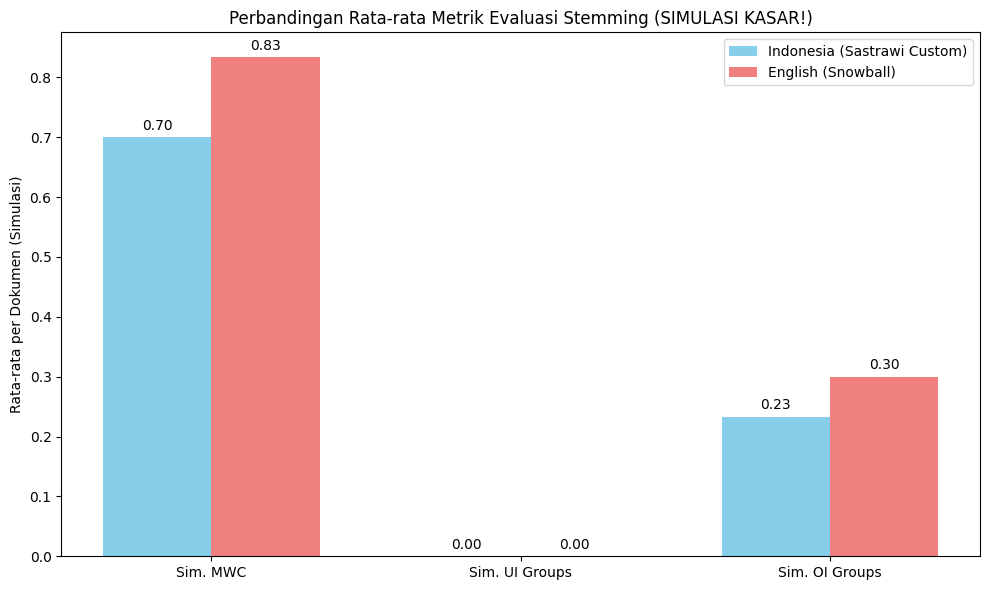

In [3]:
import os
import re
import string
import sys
import time
from collections import defaultdict

# --- Import Stemmer ---
try:
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    from Sastrawi.Dictionary.ArrayDictionary import ArrayDictionary
except ImportError:
    print("ERROR: Sastrawi library not found. Please install it: pip install sastrawi")
    sys.exit(1)

try:
    import nltk
    # Import SnowballStemmer di luar try agar selalu terdefinisi
    from nltk.stem.snowball import SnowballStemmer
    # Cek resource 'punkt', coba download jika tidak ada
    try:
        nltk.data.find('tokenizers/punkt')
    except LookupError:
        print("NLTK 'punkt' resource not found. Trying to download...")
        try:
            nltk.download('punkt', quiet=True)
            print("Download 'punkt' attempt finished.")
        except Exception as download_err:
            print(f"WARNING: Failed to download 'punkt': {download_err}")
            print("Script will continue, but some NLTK functions might fail later.")
except ImportError:
    print("ERROR: NLTK library not found. Please install it: pip install nltk")
    sys.exit(1)
# --------------------

# --- Import untuk Grafik ---
try:
    import matplotlib.pyplot as plt
    import numpy as np
except ImportError:
    print("WARNING: matplotlib or numpy not found. Plotting will be disabled.")
    print("Install them with: pip install matplotlib numpy")
    plt = None # Setel ke None jika tidak ada
    np = None
# --------------------------

# --- KONFIGURASI ---
# Folder Input
INPUT_FOLDER_INDO = 'input/indo'
INPUT_FOLDER_ENG = 'input/eng'

# Folder Output
OUTPUT_FOLDER_INDO_COMPARE = 'output/indo_comparison_simulated'
OUTPUT_FOLDER_ENG_COMPARE = 'output/eng_comparison_simulated'
OUTPUT_FOLDER_INDO_STEMMED = 'output/indo_stemmed' # Untuk IR
OUTPUT_FOLDER_ENG_STEMMED = 'output/eng_stemmed'   # Untuk IR
OUTPUT_GRAPH_FILENAME = 'output/stemming_metrics_comparison.png' # Nama file grafik

# Kamus Kata Dasar Kustom (dari gambar Anda, pastikan lowercase)
root_words_custom = set([
    "politik", "ekonomi", "olahraga", "kesehatan", "pendidikan",
    "sakit", "ajar", "main", "sehat", "kerja", "didik", "guna", "pakai",
    "tahu", "percaya", "ubah", "kaji", "nilai", "teknologi", "finance",
    "government", "education", "sport", "health", "play", "study", "run"
])
print(f"Menggunakan {len(root_words_custom)} kata dasar kustom.")
# --------------------

# --- Fungsi Helper ---

def bersihkan_teks_preserve_lines(teks):
    """Membersihkan teks per baris sambil mempertahankan struktur newline."""
    if not isinstance(teks, str): return "" # Handle non-string input
    lines = teks.split('\n')
    cleaned_lines = []
    tanda_baca_escaped = re.escape(string.punctuation)
    for line in lines:
        line = line.lower()
        line = re.sub(r"\d+", "", line) # Hapus angka
        line = re.sub(r'[' + tanda_baca_escaped + ']', '', line) # Hapus tanda baca
        line = re.sub(r'[ \t]+', ' ', line) # Spasi/tab berlebih jadi satu
        line = line.strip() # Spasi awal/akhir baris
        cleaned_lines.append(line)
    return '\n'.join(cleaned_lines)

def hitung_simulasi_metrik(list_kata_unik_cleaned, stemmer_obj, kamus_dasar_set):
    """
    Menghitung simulasi MWC, UI, OI berdasarkan peta tiruan.
    INGAT: Ini BUKAN evaluasi yang valid secara linguistik.
    """
    simulated_gold_map = {} # Peta tiruan: kata_cleaned -> stem_anggap_benar
    sastrawi_results = {}   # Peta hasil: kata_cleaned -> stem_hasil_stemmer

    # 1. Bangun peta tiruan dan dapatkan hasil Stemmer
    for kata in list_kata_unik_cleaned:
        # Pastikan tidak ada karakter aneh dan ketik ulang jika perlu
        if not kata: continue

        try: # Tambahkan try-except jika stemmer error pada kata tertentu
            hasil_stem = stemmer_obj.stem(kata)
        except Exception as stem_err:
            print(f"    Warning: Stemmer error pada kata '{kata}': {stem_err}")
            hasil_stem = kata # Jika error, anggap tidak berubah

        sastrawi_results[kata] = hasil_stem

        # Buat entri untuk peta tiruan "gold standard"
        if kata in kamus_dasar_set:
            simulated_gold_map[kata] = kata
        else:
            # Asumsi KRUSIAL: anggap hasil stemmer BENAR untuk kata non-dasar
            simulated_gold_map[kata] = hasil_stem

    # 2. Hitung Metrik Simulasi
    mwc_sim = 0
    oi_sim_groups_error = 0
    ui_sim_groups_error = 0

    # MWC Simulasi
    for kata, stem_hasil in sastrawi_results.items():
        if kata in simulated_gold_map and stem_hasil != simulated_gold_map[kata]:
            mwc_sim += 1

    # UI/OI Simulasi
    gold_groups = defaultdict(set)
    sastrawi_groups = defaultdict(set)

    for kata, stem_anggap_benar in simulated_gold_map.items():
        gold_groups[stem_anggap_benar].add(kata)
        if kata in sastrawi_results:
            sastrawi_groups[sastrawi_results[kata]].add(kata)

    # Hitung UI Simulasi
    for stem_anggap_benar, kata_di_gold_group in gold_groups.items():
        if not kata_di_gold_group or len(kata_di_gold_group) <= 1: continue
        hasil_sastrawi_untuk_grup = {sastrawi_results.get(k) for k in kata_di_gold_group if k in sastrawi_results}
        hasil_sastrawi_untuk_grup.discard(None)
        if len(hasil_sastrawi_untuk_grup) > 1:
            ui_sim_groups_error += 1

    # Hitung OI Simulasi
    for stem_sastrawi, kata_di_sastrawi_group in sastrawi_groups.items():
        if not kata_di_sastrawi_group or len(kata_di_sastrawi_group) <= 1: continue
        asal_anggap_benar_untuk_grup = {simulated_gold_map.get(k) for k in kata_di_sastrawi_group if k in simulated_gold_map}
        asal_anggap_benar_untuk_grup.discard(None)
        if len(asal_anggap_benar_untuk_grup) > 1:
            oi_sim_groups_error += 1

    return mwc_sim, ui_sim_groups_error, oi_sim_groups_error

def proses_dokumen_set(input_folder, output_folder_compare, output_folder_stemmed, stemmer_obj, kamus_dasar_set, language_name):
    """Memproses satu set dokumen (Indo atau Eng)."""
    print(f"\n--- Memproses Dokumen Bahasa: {language_name} ---")
    print(f"Input: {input_folder}")
    print(f"Output Perbandingan: {output_folder_compare}")
    print(f"Output Stemmed (IR): {output_folder_stemmed}")

    os.makedirs(output_folder_compare, exist_ok=True)
    os.makedirs(output_folder_stemmed, exist_ok=True)

    total_stats = {
        'original_words': 0, 'cleaned_words': 0, 'stemmed_words': 0,
        'unique_original': set(), 'unique_cleaned': set(), 'unique_stemmed': set(),
        'mwc_sim': 0, 'ui_sim': 0, 'oi_sim': 0,
        'processed_files': 0, 'skipped_files': 0
    }

    if not os.path.isdir(input_folder):
        print(f"WARNING: Folder input '{input_folder}' tidak ditemukan. Melewati set ini.")
        return total_stats

    try:
        list_file = os.listdir(input_folder)
        if not list_file:
            print("Folder input kosong.")
            return total_stats

        for filename in list_file:
            input_file_path = os.path.join(input_folder, filename)

            if os.path.isfile(input_file_path) and filename.lower().endswith('.txt'):
                output_file_compare_path = os.path.join(output_folder_compare, filename)
                output_file_stemmed_path = os.path.join(output_folder_stemmed, filename)

                print(f"  -> Memproses: {filename}...")
                try:
                    with open(input_file_path, 'r', encoding='utf-8', errors='ignore') as f_in:
                        original_text = f_in.read()

                    # Statistik Original
                    original_words_list = original_text.split()
                    count_original_words = len(original_words_list)
                    set_unique_original = set(w for w in original_words_list if w)
                    count_unique_original = len(set_unique_original)

                    # Cleaning
                    cleaned_text = bersihkan_teks_preserve_lines(original_text)

                    # Stemming
                    stemmed_text = stemmer_obj.stem(cleaned_text) # Gunakan stemmer yang sesuai

                    # Simpan HANYA stemmed text untuk IR
                    with open(output_file_stemmed_path, 'w', encoding='utf-8') as f_stem_out:
                        f_stem_out.write(stemmed_text)

                    # Statistik Dasar Cleaned & Stemmed
                    valid_cleaned_words = [w for w in cleaned_text.split() if w]
                    valid_stemmed_words = [w for w in stemmed_text.split() if w]
                    count_cleaned_words = len(valid_cleaned_words)
                    set_unique_cleaned = set(valid_cleaned_words); count_unique_cleaned = len(set_unique_cleaned)
                    count_stemmed_words = len(valid_stemmed_words)
                    set_unique_stemmed = set(valid_stemmed_words); count_unique_stemmed = len(set_unique_stemmed)

                    # Hitung Metrik Simulasi
                    list_unik_cleaned = list(set_unique_cleaned)
                    mwc_sim_file, ui_sim_file, oi_sim_file = hitung_simulasi_metrik(
                        list_unik_cleaned, stemmer_obj, kamus_dasar_set
                    )

                    # Buat Header File Output Perbandingan
                    file_header = f"""=============================================
FILE: {filename} - STATISTIK & METRIK SIMULASI ({language_name})
=============================================
A. STATISTIK DASAR:
   Jumlah Kata (Original): {count_original_words}
   Jumlah Kata Unik (Original): {count_unique_original}
   ------------------------------------------
   Jumlah Kata (Setelah Cleaning): {count_cleaned_words}
   Jumlah Kata Unik (Setelah Cleaning): {count_unique_cleaned}
   ------------------------------------------
   Jumlah Kata (Setelah Stemming): {count_stemmed_words}
   Jumlah Kata Unik (Setelah Stemming): {count_unique_stemmed}
---------------------------------------------
B. METRIK EVALUASI SIMULASI (PERKIRAAN SANGAT KASAR!):
   Simulated MWC (Mis-stemmed*): {mwc_sim_file}
   Simulated UI (Under-stemming Groups**): {ui_sim_file}
   Simulated OI (Over-stemming Groups***): {oi_sim_file}
=============================================
CATATAN SANGAT PENTING:
Angka MWC, UI, OI di atas adalah HASIL SIMULASI berdasarkan asumsi internal
dan kamus dasar kustom. Ini BUKAN evaluasi linguistik yang valid dan
TIDAK MENGGUNAKAN GOLD STANDARD STEMMING yang sebenarnya. Gunakan HANYA
untuk perbandingan relatif kasar dalam eksperimen internal Anda.
*   Simulated MWC: Jumlah kata unik yang stem hasil != stem 'benar' peta tiruan.
**  Simulated UI: Jumlah kelompok stem 'benar' (peta tiruan) yg hasilnya terpecah.
*** Simulated OI: Jumlah kelompok stem hasil yg mencampur asal 'benar' yg beda.

-> Interpretasikan angka Simulasi MWC, UI, OI dengan SANGAT HATI-HATI! <-

"""
                    separator_cleaned = "\n--- TEKS SETELAH CLEANING (SEBELUM STEMMING) ---\n"
                    separator_stemmed = "\n\n--- TEKS SETELAH STEMMING ---\n"
                    final_comparison_content = (file_header + separator_cleaned + cleaned_text + separator_stemmed + stemmed_text)

                    # Tulis file perbandingan
                    with open(output_file_compare_path, 'w', encoding='utf-8') as f_comparison:
                        f_comparison.write(final_comparison_content)

                    # Akumulasi Statistik Total
                    total_stats['original_words'] += count_original_words
                    total_stats['cleaned_words'] += count_cleaned_words
                    total_stats['stemmed_words'] += count_stemmed_words
                    total_stats['unique_original'].update(set_unique_original)
                    total_stats['unique_cleaned'].update(set_unique_cleaned)
                    total_stats['unique_stemmed'].update(set_unique_stemmed)
                    total_stats['mwc_sim'] += mwc_sim_file
                    total_stats['ui_sim'] += ui_sim_file
                    total_stats['oi_sim'] += oi_sim_file
                    total_stats['processed_files'] += 1

                except Exception as e:
                    print(f"     ERROR saat memproses file {filename}: {e}")
            else:
                # Log skip file
                if os.path.isfile(input_file_path): print(f"  -> Melewati file non-txt: {filename}")
                elif os.path.exists(input_file_path): print(f"  -> Melewati item non-file: {filename}")
                else: print(f"  -> Path tidak valid: {filename}")
                total_stats['skipped_files'] += 1

    except FileNotFoundError: # Error jika folder input tidak ada
        print(f"WARNING: Folder input '{input_folder}' tidak ditemukan.")
    except Exception as e:
        print(f"ERROR saat memproses folder {input_folder}: {e}")

    print(f"--- Selesai memproses {language_name} ({total_stats['processed_files']} file) ---")
    return total_stats

def cari_dokumen(query, language, stemmed_docs_folder, stemmer_obj, top_n=5):
    """Mencari dokumen berdasarkan query yang di-stem."""
    print(f"\n--- Mencari Dokumen ({language}) untuk Query: '{query}' ---")
    if not os.path.isdir(stemmed_docs_folder):
        print(f"ERROR: Folder dokumen stemmed '{stemmed_docs_folder}' tidak ditemukan.")
        return []

    # 1. Bersihkan dan stem query
    cleaned_query = bersihkan_teks_preserve_lines(query)
    query_stems = set(w for w in stemmer_obj.stem(cleaned_query).split() if w)
    if not query_stems:
        print("Query tidak menghasilkan stem yang valid setelah dibersihkan.")
        return []
    print(f"Stem Query: {query_stems}")

    # 2. Hitung skor relevansi (simple matching count)
    doc_scores = {}
    try:
        for filename in os.listdir(stemmed_docs_folder):
            if filename.lower().endswith('.txt'):
                filepath = os.path.join(stemmed_docs_folder, filename)
                try:
                    with open(filepath, 'r', encoding='utf-8') as f:
                        stemmed_content = f.read()
                        doc_stems = set(w for w in stemmed_content.split() if w)
                        # Skor = jumlah kata stem query yang cocok
                        score = len(query_stems.intersection(doc_stems))
                        if score > 0:
                            doc_scores[filename] = score
                except Exception as e:
                    print(f"  Warning: Gagal membaca/memproses file stemmed {filename}: {e}")

    except Exception as e:
        print(f"ERROR saat mengakses folder stemmed {stemmed_docs_folder}: {e}")
        return []

    # 3. Urutkan dokumen berdasarkan skor
    sorted_docs = sorted(doc_scores.items(), key=lambda item: item[1], reverse=True)

    # 4. Kembalikan top N
    print(f"Dokumen teratas yang relevan (Top {top_n}):")
    if not sorted_docs:
        print("Tidak ada dokumen yang cocok ditemukan.")
        return []

    results = []
    for i, (doc, score) in enumerate(sorted_docs[:top_n]):
        print(f"{i+1}. {doc} (Skor: {score})")
        results.append((doc, score))
    return results

def plot_comparison_graph(stats_indo, stats_eng, output_filename):
    """Membuat grafik batang perbandingan metrik simulasi rata-rata."""
    # Hanya jalankan jika matplotlib dan numpy berhasil diimpor
    if plt is None or np is None:
        print("\nSkipping plot generation: matplotlib or numpy not installed.")
        return

    print("\n--- Membuat Grafik Perbandingan Metrik Simulasi ---")

    labels = ['Sim. MWC', 'Sim. UI Groups', 'Sim. OI Groups']
    total_files_indo = stats_indo.get('processed_files', 0)
    total_files_eng = stats_eng.get('processed_files', 0)

    # Hitung rata-rata, hindari pembagian dengan nol
    avg_mwc_indo = stats_indo.get('mwc_sim', 0) / total_files_indo if total_files_indo else 0
    avg_ui_indo = stats_indo.get('ui_sim', 0) / total_files_indo if total_files_indo else 0
    avg_oi_indo = stats_indo.get('oi_sim', 0) / total_files_indo if total_files_indo else 0

    avg_mwc_eng = stats_eng.get('mwc_sim', 0) / total_files_eng if total_files_eng else 0
    avg_ui_eng = stats_eng.get('ui_sim', 0) / total_files_eng if total_files_eng else 0
    avg_oi_eng = stats_eng.get('oi_sim', 0) / total_files_eng if total_files_eng else 0

    indo_means = [avg_mwc_indo, avg_ui_indo, avg_oi_indo]
    eng_means = [avg_mwc_eng, avg_ui_eng, avg_oi_eng]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    try:
        fig, ax = plt.subplots(figsize=(10, 6)) # Atur ukuran figure
        rects1 = ax.bar(x - width/2, indo_means, width, label='Indonesia (Sastrawi Custom)', color='skyblue')
        rects2 = ax.bar(x + width/2, eng_means, width, label='English (Snowball)', color='lightcoral')

        # Tambahkan teks label, judul, dan tick label sumbu kustom, dll.
        ax.set_ylabel('Rata-rata per Dokumen (Simulasi)')
        ax.set_title('Perbandingan Rata-rata Metrik Evaluasi Stemming (SIMULASI KASAR!)')
        ax.set_xticks(x)
        ax.set_xticklabels(labels)
        ax.legend()

        # Fungsi untuk menambahkan label di atas bar
        def add_labels(rects):
             for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.2f}',
                            xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3),  # 3 points vertical offset
                            textcoords="offset points",
                            ha='center', va='bottom')

        add_labels(rects1)
        add_labels(rects2)

        fig.tight_layout() # Atur layout agar rapi

        # Pastikan direktori output untuk grafik ada
        output_dir = os.path.dirname(output_filename)
        if output_dir: # Cek jika ada direktori (bukan hanya nama file)
            os.makedirs(output_dir, exist_ok=True)

        plt.savefig(output_filename)
        print(f"Grafik perbandingan disimpan ke: {output_filename}")
        # plt.show() # Komentari jika tidak ingin otomatis muncul

    except Exception as plot_err:
        print(f"WARNING: Gagal membuat atau menyimpan grafik: {plot_err}")

def print_stats_comparison(stats_indo, stats_eng):
    """Mencetak perbandingan statistik total dalam format tabel."""
    total_files_indo = stats_indo.get('processed_files', 0)
    total_files_eng = stats_eng.get('processed_files', 0)
    print(f"\n{'Metrik':<40} | {'Indonesia':<20} | {'English':<20}")
    print("-" * 85)
    print(f"{'Jumlah Dokumen Diproses':<40} | {total_files_indo:<20} | {total_files_eng:<20}")
    print(f"{'Jumlah Dokumen Dilewati':<40} | {stats_indo.get('skipped_files', 0):<20} | {stats_eng.get('skipped_files', 0):<20}")
    print("-" * 85)
    print("Statistik Kata (Total):")
    print(f"{'  Total Kata Original':<38} | {stats_indo.get('original_words', 0):<20} | {stats_eng.get('original_words', 0):<20}")
    print(f"{'  Total Kata Cleaned':<38} | {stats_indo.get('cleaned_words', 0):<20} | {stats_eng.get('cleaned_words', 0):<20}")
    print(f"{'  Total Kata Stemmed':<38} | {stats_indo.get('stemmed_words', 0):<20} | {stats_eng.get('stemmed_words', 0):<20}")
    print("-" * 85)
    print("Statistik Kata Unik (Total):")
    unique_ori_indo = len(stats_indo.get('unique_original', set())); unique_ori_eng = len(stats_eng.get('unique_original', set()))
    unique_clean_indo = len(stats_indo.get('unique_cleaned', set())); unique_clean_eng = len(stats_eng.get('unique_cleaned', set()))
    unique_stem_indo = len(stats_indo.get('unique_stemmed', set())); unique_stem_eng = len(stats_eng.get('unique_stemmed', set()))
    print(f"{'  Unik Original':<38} | {unique_ori_indo:<20} | {unique_ori_eng:<20}")
    print(f"{'  Unik Cleaned':<38} | {unique_clean_indo:<20} | {unique_clean_eng:<20}")
    print(f"{'  Unik Stemmed':<38} | {unique_stem_indo:<20} | {unique_stem_eng:<20}")
    print("-" * 85)
    print("METRIK EVALUASI SIMULASI (Total - PERKIRAAN KASAR):")
    print(f"{'  Total Simulated MWC':<38} | {stats_indo.get('mwc_sim', 0):<20} | {stats_eng.get('mwc_sim', 0):<20}")
    print(f"{'  Total Simulated UI Groups':<38} | {stats_indo.get('ui_sim', 0):<20} | {stats_eng.get('ui_sim', 0):<20}")
    print(f"{'  Total Simulated OI Groups':<38} | {stats_indo.get('oi_sim', 0):<20} | {stats_eng.get('oi_sim', 0):<20}")
    print("-" * 85)
    print("Rata-rata Metrik Simulasi per Dokumen (Jika > 0 dokumen):")
    avg_mwc_indo = stats_indo.get('mwc_sim', 0) / total_files_indo if total_files_indo else 0
    avg_ui_indo = stats_indo.get('ui_sim', 0) / total_files_indo if total_files_indo else 0
    avg_oi_indo = stats_indo.get('oi_sim', 0) / total_files_indo if total_files_indo else 0
    avg_mwc_eng = stats_eng.get('mwc_sim', 0) / total_files_eng if total_files_eng else 0
    avg_ui_eng = stats_eng.get('ui_sim', 0) / total_files_eng if total_files_eng else 0
    avg_oi_eng = stats_eng.get('oi_sim', 0) / total_files_eng if total_files_eng else 0
    print(f"{'  Avg. Simulated MWC':<38} | {avg_mwc_indo:<20.2f} | {avg_mwc_eng:<20.2f}")
    print(f"{'  Avg. Simulated UI Groups':<38} | {avg_ui_indo:<20.2f} | {avg_ui_eng:<20.2f}")
    print(f"{'  Avg. Simulated OI Groups':<38} | {avg_oi_indo:<20.2f} | {avg_oi_eng:<20.2f}")
    print("-" * 85)
# --- Akhir Fungsi Helper ---


# --- PROGRAM UTAMA ---
if __name__ == "__main__":
    start_pipeline_time = time.time()

    # Inisialisasi Stemmer
    print("--- Inisialisasi Stemmer ---")
    sastrawi_stemmer = None
    snowball_stemmer = None
    try:
        # Sastrawi dengan kamus kustom
        sastrawi_custom_dict = ArrayDictionary(list(root_words_custom))
        sastrawi_factory = StemmerFactory() # Factory tanpa argumen
        sastrawi_stemmer = sastrawi_factory.create_stemmer(sastrawi_custom_dict) # Kamus saat create_stemmer
        print("Stemmer Sastrawi (Kamus Kustom) siap.")

        # Snowball untuk Inggris
        snowball_stemmer = SnowballStemmer('english')
        print("Stemmer Snowball (English) siap.")
    except NameError as ne:
         # Menangkap jika SnowballStemmer belum terdefinisi karena import NLTK gagal total
         print(f"ERROR: Gagal menginisialisasi stemmer - Nama tidak terdefinisi: {ne}")
         print("Pastikan library NLTK terinstal dengan benar.")
         sys.exit(1)
    except Exception as e:
        print(f"ERROR: Gagal menginisialisasi stemmer lain: {e}")
        sys.exit(1)
    print("-----------------------------")

    # Pastikan kedua stemmer berhasil diinisialisasi
    if sastrawi_stemmer is None or snowball_stemmer is None:
         print("ERROR: Tidak semua stemmer berhasil diinisialisasi. Program berhenti.")
         sys.exit(1)

    # Proses Dokumen Indonesia
    stats_indo = proses_dokumen_set(
        INPUT_FOLDER_INDO,
        OUTPUT_FOLDER_INDO_COMPARE,
        OUTPUT_FOLDER_INDO_STEMMED,
        sastrawi_stemmer,
        root_words_custom, # Kamus dasar digunakan untuk perhitungan metrik simulasi
        "Indonesia"
    )

    # Proses Dokumen Inggris
    stats_eng = proses_dokumen_set(
        INPUT_FOLDER_ENG,
        OUTPUT_FOLDER_ENG_COMPARE,
        OUTPUT_FOLDER_ENG_STEMMED,
        snowball_stemmer,
        root_words_custom, # Kamus dasar kustom dipakai juga untuk konsistensi (meski kurang relevan utk Snowball)
        "English"
    )

    # --- Ringkasan Teks ---
    print("\n\n--- RINGKASAN STATISTIK TOTAL & PERBANDINGAN ---")
    print_stats_comparison(stats_indo, stats_eng)
    print("PERINGATAN: Ingatlah bahwa Metrik MWC, UI, OI adalah simulasi kasar!")

    # --- Buat dan Tampilkan Grafik ---
    # Hanya buat grafik jika matplotlib tersedia dan ada data
    if plt and np and (stats_indo.get('processed_files', 0) > 0 or stats_eng.get('processed_files', 0) > 0):
        plot_comparison_graph(stats_indo, stats_eng, OUTPUT_GRAPH_FILENAME)
    else:
        if not plt or not np:
             print("\nGrafik tidak dibuat karena matplotlib atau numpy tidak terinstal.")
        else:
             print("\nTidak ada dokumen yang diproses, grafik tidak dibuat.")

    # --- Contoh Information Retrieval ---
    print("\n\n--- CONTOH INFORMATION RETRIEVAL ---")
    contoh_query_indo = "kajian tentang pendidikan teknologi"
    hasil_cari_indo = cari_dokumen(
        contoh_query_indo, "Indonesia", OUTPUT_FOLDER_INDO_STEMMED, sastrawi_stemmer, top_n=3
    )
    print("-" * 30)
    contoh_query_eng = "studies about health and education technology"
    hasil_cari_eng = cari_dokumen(
        contoh_query_eng, "English", OUTPUT_FOLDER_ENG_STEMMED, snowball_stemmer, top_n=3
    )
    print("--------------------------------------")

    end_pipeline_time = time.time()
    print(f"\nTotal waktu eksekusi pipeline: {end_pipeline_time - start_pipeline_time:.2f} detik")
    print("Pipeline Selesai.")

Hasil Pencarian Sebelum vs Setelah Stemming (Top Skor)

Query: education
  -> Top doc before stemming: 7
  -> Top doc after stemming: 0

Query: ekonomi
  -> Top doc before stemming: 14
  -> Top doc after stemming: 15

Query: finance
  -> Top doc before stemming: 1
  -> Top doc after stemming: 0

Query: government
  -> Top doc before stemming: 11
  -> Top doc after stemming: 0

Query: health
  -> Top doc before stemming: 8
  -> Top doc after stemming: 8

Query: kesehatan
  -> Top doc before stemming: 9
  -> Top doc after stemming: 12

Query: olahraga
  -> Top doc before stemming: 0
  -> Top doc after stemming: 1

Query: pendidikan
  -> Top doc before stemming: 12
  -> Top doc after stemming: 13

Query: politik
  -> Top doc before stemming: 9
  -> Top doc after stemming: 9

Query: sport
  -> Top doc before stemming: 1
  -> Top doc after stemming: 1
Grafik hasil pencarian disimpan ke: output/search_comparison_all.png

Total waktu eksekusi: 0.52 detik


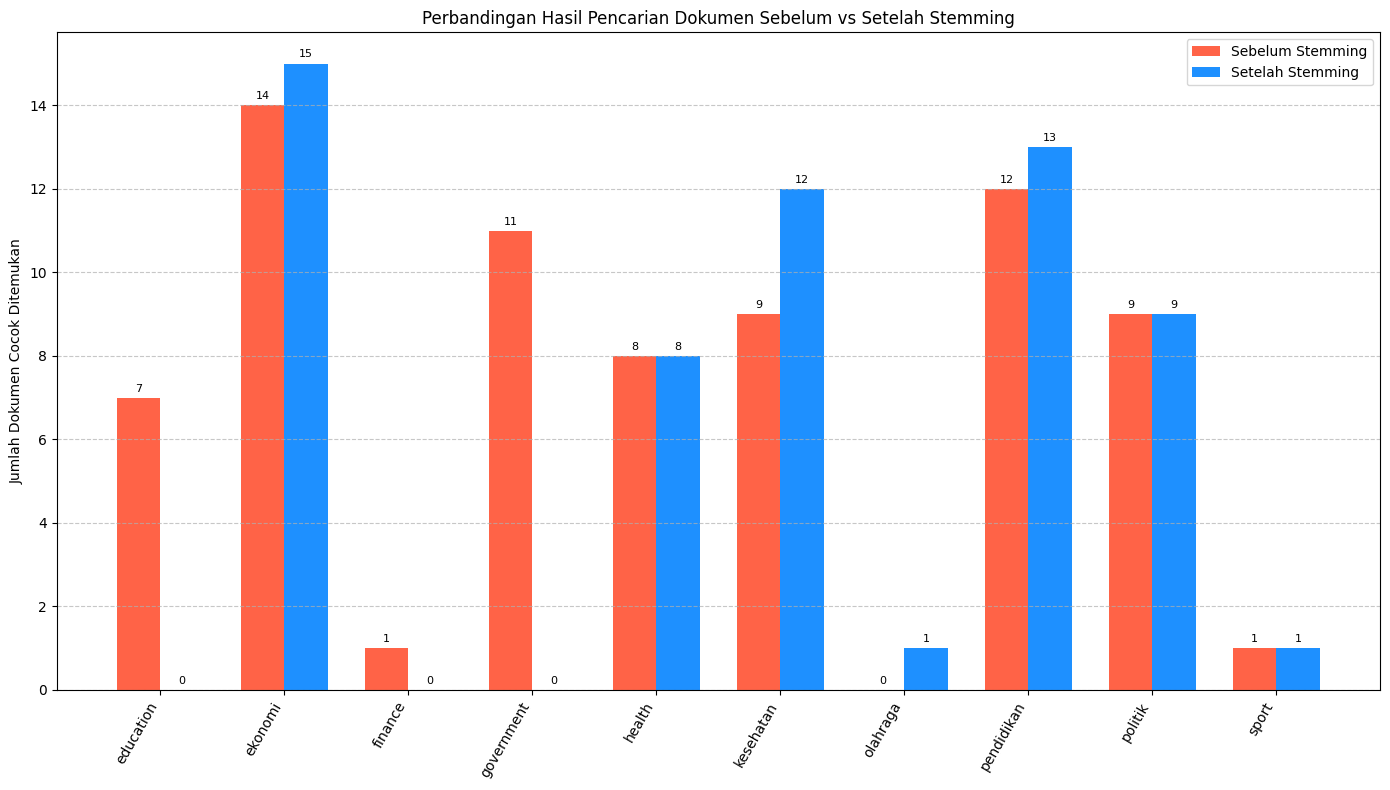

In [4]:
# -*- coding: utf-8 -*-
import os
import re
import string
import sys
import time
from collections import defaultdict

try:
    from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
    from Sastrawi.Dictionary.ArrayDictionary import ArrayDictionary
except ImportError:
    print("ERROR: Sastrawi library not found. Please install it: pip install sastrawi")
    sys.exit(1)

try:
    import nltk
    from nltk.stem.snowball import SnowballStemmer
except ImportError:
    print("ERROR: NLTK library not found. Please install it: pip install nltk")
    sys.exit(1)

try:
    import matplotlib.pyplot as plt
    import numpy as np
except ImportError:
    print("WARNING: matplotlib or numpy not found. Plotting will be disabled.")
    print("Install them with: pip install matplotlib numpy")
    plt = None
    np = None

# --- KONFIGURASI ---
INPUT_FOLDER_INDO = 'input/indo'
INPUT_FOLDER_ENG = 'input/eng'
STEMMED_FOLDER_INDO = 'output/indo_stemmed'
STEMMED_FOLDER_ENG = 'output/eng_stemmed'
OUTPUT_FOLDER_GRAPHS = 'output/'

root_words_custom = set([
    "politik", "ekonomi", "olahraga", "kesehatan", "pendidikan",
    "sakit", "ajar", "main", "sehat", "kerja", "didik", "guna", "pakai",
    "tahu", "percaya", "ubah", "kaji", "nilai", "teknologi", "finance",
    "government", "education", "sport", "health", "play", "study", "run"
])

QUERIES_TO_TEST = [
    "politik", "ekonomi", "olahraga", "kesehatan", "pendidikan",
    "government", "sport", "education", "finance", "health"
]
OUTPUT_GRAPH_FILENAME_SEARCH = os.path.join(OUTPUT_FOLDER_GRAPHS, 'search_comparison_all.png')
# --- Akhir Konfigurasi ---

def bersihkan_teks_sederhana(teks):
    if not isinstance(teks, str): return ""
    teks = teks.lower()
    teks = re.sub(r"\d+", "", teks)
    teks = teks.translate(str.maketrans('', '', string.punctuation))
    teks = re.sub(r'\s+', ' ', teks).strip()
    return teks

def get_terms_set(text):
    return set(w for w in text.split() if w)

def cari_sebelum_stem(query_terms_set, input_folder):
    count = 0
    if not os.path.isdir(input_folder):
        return 0
    try:
        for filename in os.listdir(input_folder):
            if filename.lower().endswith('.txt'):
                filepath = os.path.join(input_folder, filename)
                try:
                    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
                        original_content = f.read()
                    cleaned_content = bersihkan_teks_sederhana(original_content)
                    doc_terms_set = get_terms_set(cleaned_content)
                    if not query_terms_set.isdisjoint(doc_terms_set):
                        count += 1
                except Exception:
                    pass # Ignore file read/process errors in this simplified version
    except Exception:
        pass # Ignore folder access errors
    return count

def cari_setelah_stem(query_stems_set, stemmed_folder):
    count = 0
    if not os.path.isdir(stemmed_folder):
        return 0
    try:
        for filename in os.listdir(stemmed_folder):
            if filename.lower().endswith('.txt'):
                filepath = os.path.join(stemmed_folder, filename)
                try:
                    with open(filepath, 'r', encoding='utf-8', errors='ignore') as f:
                        stemmed_content = f.read()
                    doc_stems_set = get_terms_set(stemmed_content)
                    if not query_stems_set.isdisjoint(doc_stems_set):
                        count += 1
                except Exception:
                     pass # Ignore file read/process errors
    except Exception:
        pass # Ignore folder access errors
    return count

def plot_hasil_pencarian(results_dict, output_filename):
    if plt is None or np is None: return
    if not results_dict: return

    valid_results = {q: r for q, r in results_dict.items() if isinstance(r.get('before'), int) and isinstance(r.get('after'), int)}
    if not valid_results: return

    queries = sorted(valid_results.keys())
    before_counts = [valid_results[q]['before'] for q in queries]
    after_counts = [valid_results[q]['after'] for q in queries]
    labels = queries

    x = np.arange(len(labels))
    width = 0.35

    try:
        fig, ax = plt.subplots(figsize=(14, 8))
        rects1 = ax.bar(x - width/2, before_counts, width, label='Sebelum Stemming', color='tomato')
        rects2 = ax.bar(x + width/2, after_counts, width, label='Setelah Stemming', color='dodgerblue')

        ax.set_ylabel('Jumlah Dokumen Cocok Ditemukan')
        ax.set_title('Perbandingan Hasil Pencarian Dokumen Sebelum vs Setelah Stemming')
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=60, ha="right")
        ax.legend()
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        def add_labels(rects):
             for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height}', xy=(rect.get_x() + rect.get_width() / 2, height),
                            xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=8)
        add_labels(rects1)
        add_labels(rects2)

        fig.tight_layout()
        output_dir = os.path.dirname(output_filename)
        if output_dir: os.makedirs(output_dir, exist_ok=True)
        plt.savefig(output_filename)
        print(f"Grafik hasil pencarian disimpan ke: {output_filename}")
        # plt.show()
    except Exception as plot_err:
        print(f"WARNING: Gagal membuat atau menyimpan grafik: {plot_err}")

if __name__ == "__main__":
    start_time = time.time()
    sastrawi_stemmer = None; snowball_stemmer = None
    try:
        sastrawi_custom_dict = ArrayDictionary(list(root_words_custom))
        sastrawi_factory = StemmerFactory()
        sastrawi_stemmer = sastrawi_factory.create_stemmer(sastrawi_custom_dict)
        snowball_stemmer = SnowballStemmer('english')
    except Exception as e: print(f"ERROR: Gagal init stemmer: {e}"); sys.exit(1)

    search_results = defaultdict(lambda: {'before': 0, 'after': 0, 'lang': 'unknown'})

    for query in QUERIES_TO_TEST:
        is_indo = query in root_words_custom and query not in ["finance", "government", "education", "sport", "health", "play", "study", "run", "technology"]

        if is_indo:
            lang = "Indonesia"; input_folder_ori = INPUT_FOLDER_INDO
            stemmed_folder = STEMMED_FOLDER_INDO; stemmer_obj = sastrawi_stemmer
            search_results[query]['lang'] = 'indo'
        else:
            lang = "English"; input_folder_ori = INPUT_FOLDER_ENG
            stemmed_folder = STEMMED_FOLDER_ENG; stemmer_obj = snowball_stemmer
            search_results[query]['lang'] = 'eng'

        cleaned_query = bersihkan_teks_sederhana(query)
        query_terms_set = get_terms_set(cleaned_query)
        query_stems_set = set()
        if query_terms_set:
             try: query_stems_set = get_terms_set(stemmer_obj.stem(cleaned_query))
             except Exception: pass

        count_before = 0
        if query_terms_set: count_before = cari_sebelum_stem(query_terms_set, input_folder_ori)
        search_results[query]['before'] = count_before

        count_after = 0
        if query_stems_set: count_after = cari_setelah_stem(query_stems_set, stemmed_folder)
        search_results[query]['after'] = count_after

    print("Hasil Pencarian Sebelum vs Setelah Stemming (Top Skor)") # Judul output
    for query in sorted(search_results.keys()):
        result = search_results[query]
        print(f"\nQuery: {query}")
        print(f"  -> Top doc before stemming: {result['before']}")
        print(f"  -> Top doc after stemming: {result['after']}")

    plot_hasil_pencarian(search_results, OUTPUT_GRAPH_FILENAME_SEARCH)

    end_time = time.time()
    print(f"\nTotal waktu eksekusi: {end_time - start_time:.2f} detik")